In [2]:
# Imports 
import spacy
import random
import json
import matplotlib.pyplot as plt

from spacy.util import minibatch, compounding
from spacy.training.example import Example
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score 


In [3]:
# Load data
with open('../nlpDataSet/train.json', 'r') as file:
    data = json.load(file)
with open('../nlpDataSet/test.json', 'r') as file:
    test_data = json.load(file)

# Training

In [4]:
# Data preparation
train_data = []
for item in data:
    text = item['sentence']
    entities = item['entities']
    ents = []
    for ent in entities:
        ents.append((ent['start'], ent['end'], ent['label']))
    train_data.append((text, {"entities": ents}))
    
num_positives = len([item for item in train_data if len(item[1]["entities"]) > 0])
num_negatives = len([item for item in train_data if len(item[1]["entities"]) == 0])
print(f"Exemples positifs : {num_positives}, Exemples négatifs : {num_negatives}")

print(f"Exemple d'entraînement : {train_data[0]}")


Exemples positifs : 794, Exemples négatifs : 806
Exemple d'entraînement : ('je prends le train de grenoble à bois-le-roi le 14 avril à 14h30.', {'entities': [(22, 30, 'VILLE_DEPART'), (33, 44, 'VILLE_DESTINATION')]})


In [5]:
# Model creation
nlp = spacy.load("fr_core_news_md")
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

labels = ["VILLE_DEPART", "VILLE_DESTINATION"]
for label in labels:
    ner.add_label(label)
    
# Make sure that the model handles no-entity examples correctly
optimizer = nlp.resume_training()


In [6]:
# Training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
    n_iter = 20
    for itn in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(2.0, 16.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            examples = []
            for text, annotation in zip(texts, annotations):
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotation)
                examples.append(example)
            nlp.update(examples, sgd=optimizer, drop=0.30, losses=losses)
        print(f"Itération {itn + 1}, pertes : {losses}")

Itération 1, pertes : {'ner': np.float32(1117.6649)}
Itération 2, pertes : {'ner': np.float32(268.7558)}
Itération 3, pertes : {'ner': np.float32(151.17288)}
Itération 4, pertes : {'ner': np.float32(104.20525)}
Itération 5, pertes : {'ner': np.float32(113.247375)}
Itération 6, pertes : {'ner': np.float32(68.67017)}
Itération 7, pertes : {'ner': np.float32(63.619583)}
Itération 8, pertes : {'ner': np.float32(68.435)}
Itération 9, pertes : {'ner': np.float32(64.142)}
Itération 10, pertes : {'ner': np.float32(59.367455)}
Itération 11, pertes : {'ner': np.float32(39.909996)}
Itération 12, pertes : {'ner': np.float32(46.90706)}
Itération 13, pertes : {'ner': np.float32(30.773113)}
Itération 14, pertes : {'ner': np.float32(48.668724)}
Itération 15, pertes : {'ner': np.float32(46.26702)}
Itération 16, pertes : {'ner': np.float32(60.119987)}
Itération 17, pertes : {'ner': np.float32(52.893837)}
Itération 18, pertes : {'ner': np.float32(47.419956)}
Itération 19, pertes : {'ner': np.float32(56.7

In [7]:
# Save the model
nlp.to_disk("model_ner_trained")

# Testing

In [8]:
nlp_trained = spacy.load("model_ner_trained")
nlp_not_trained = spacy.load("fr_core_news_md")

In [9]:
sentences = [item['sentence'] for item in test_data]
true_labels = [item['entities'] for item in test_data]

In [10]:
# Prediction
def get_pred_labels(nlp_model, sentences):
    pred_labels = []
    for sentence in sentences:
        doc = nlp_model(sentence)
        pred_labels.append([(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])
    return pred_labels 

In [11]:
# Conversion of true and predicted labels
def convert_labels(true_labels, pred_labels):
    y_true = []
    y_pred = []
    for true, pred in zip(true_labels, pred_labels):
        true_set = set((entity['start'], entity['end'], entity['label']) for entity in true)
        pred_set = set(pred)
        
        if not true_set and not pred_set:
            y_true.append(False)  
            y_pred.append(False)
        for label in true_set.union(pred_set):
            y_true.append(label in true_set)
            y_pred.append(label in pred_set)
    
    return y_true, y_pred

In [12]:
# Adjusting the labels of the not trained model because it doesn't have the 'VILLE_DEPART' and 'VILLE_DESTINATION' labels
def adjust_not_trained_labels(pred_labels):
    adjusted_labels = []
    for labels in pred_labels:
        adjusted = []
        for i, (start, end, label) in enumerate(labels):
            if label == 'LOC':
                if i == 0: 
                    adjusted.append((start, end, 'VILLE_DEPART'))
                else:
                    adjusted.append((start, end, 'VILLE_DESTINATION'))
            else:
                adjusted.append((start, end, label))
        adjusted_labels.append(adjusted)
    return adjusted_labels

In [13]:
pred_labels_trained = get_pred_labels(nlp_trained, sentences)
pred_labels_not_trained = get_pred_labels(nlp_not_trained, sentences)
adjusted_labels_not_trained = adjust_not_trained_labels(pred_labels_not_trained)

In [14]:
y_true_trained, y_pred_trained = convert_labels(true_labels, pred_labels_trained)
y_true_not_trained, y_pred_not_trained = convert_labels(true_labels, adjusted_labels_not_trained)

In [16]:
# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    
    #  Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Classification report
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:\n", class_report)
    
    # Précision-Recall pour les données true
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    # Precision-Recall curve plot
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # ROC and AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # ROC curve display
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

Model: Trained Model
Confusion Matrix:
 [[189  20]
 [ 21 391]]
Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90       209
        True       0.95      0.95      0.95       412

    accuracy                           0.93       621
   macro avg       0.93      0.93      0.93       621
weighted avg       0.93      0.93      0.93       621



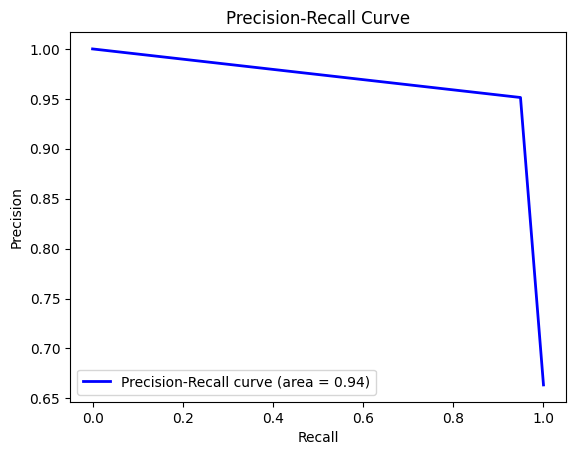

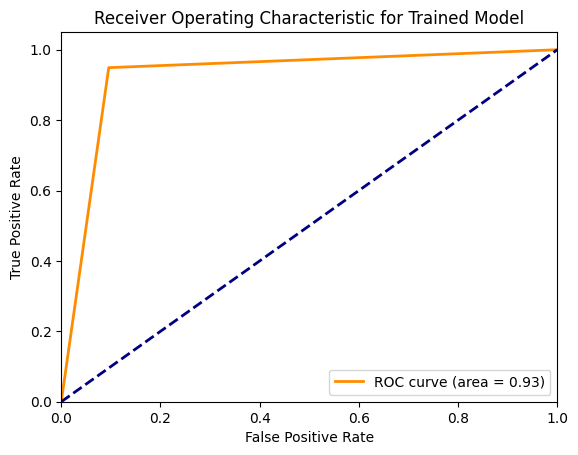

Model: Not Trained Model
Confusion Matrix:
 [[ 82 240]
 [231 181]]
Classification Report:
               precision    recall  f1-score   support

       False       0.26      0.25      0.26       322
        True       0.43      0.44      0.43       412

    accuracy                           0.36       734
   macro avg       0.35      0.35      0.35       734
weighted avg       0.36      0.36      0.36       734



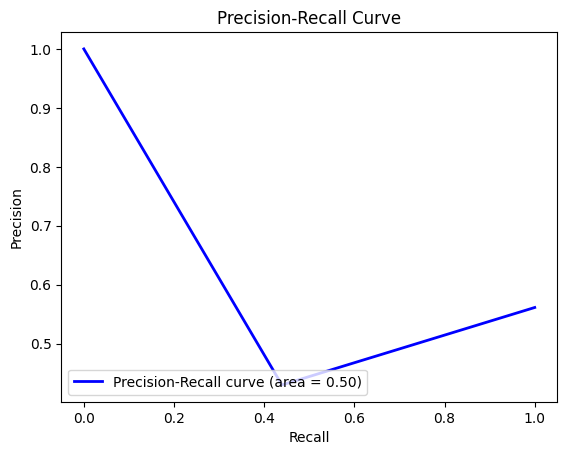

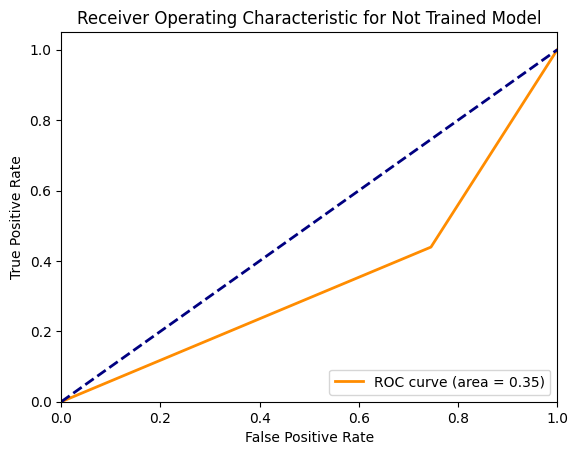

In [17]:
evaluate_model(y_true_trained, y_pred_trained, "Trained Model")
evaluate_model(y_true_not_trained, y_pred_not_trained, "Not Trained Model")